In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
pd.options.display.max_columns=500
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [4]:
fp = pd.read_csv('trainfp.csv')

In [5]:
fp.head()
#First lets look at the data

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [6]:
fp['Policy_Sales_Channel'].value_counts(dropna=False)

152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
144.0         1
149.0         1
84.0          1
143.0         1
43.0          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

In [7]:
fp['Vintage'].unique()

array([217, 183,  27, 203,  39, 176, 249,  72,  28,  80,  46, 289, 221,
        15,  58, 147, 256, 299, 158, 102, 116, 177, 232,  60, 180,  49,
        57, 223, 136, 222, 149, 169,  88, 253, 107, 264, 233,  45, 184,
       251, 153, 186,  71,  34,  83,  12, 246, 141, 216, 130, 282,  73,
       171, 283, 295, 165,  30, 218,  22,  36,  79,  81, 100,  63, 242,
       277,  61, 111, 167,  74, 235, 131, 243, 248, 114, 281,  62, 189,
       139, 138, 209, 254, 291,  68,  92,  52,  78, 156, 247, 275,  77,
       181, 229, 166,  16,  23,  31, 293, 219,  50, 155,  66, 260,  19,
       258, 117, 193, 204, 212, 144, 234, 206, 228, 125,  29,  18,  84,
       230,  54, 123, 101,  86,  13, 237,  85,  98,  67, 128,  95,  89,
        99, 208, 134, 135, 268, 284, 119, 226, 105, 142, 207, 272, 263,
        64,  40, 245, 163,  24, 265, 202, 259,  91, 106, 190, 162,  33,
       194, 287, 292,  69, 239, 132, 255, 152, 121, 150, 143, 198, 103,
       127, 285, 214, 151, 199,  56,  59, 215, 104, 238, 120,  2

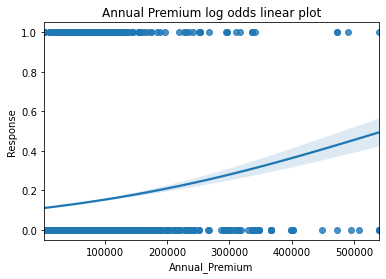

In [8]:
Annual_premium = sns.regplot(x= 'Annual_Premium', y= 'Response', data= fp, logistic= True).set_title("Annual Premium log odds linear plot")
#This takes a long time, like 5+ minutes long
#Not a "U" shape, slight "S" shape Assumption of IV's log odds linearity seems intact

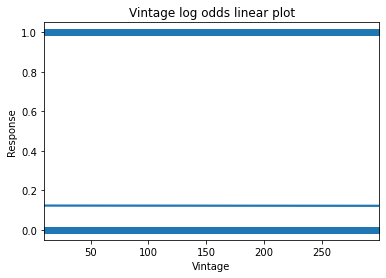

In [11]:
Days_With = sns.regplot(x= 'Vintage', y= 'Response', data= fp, logistic= True).set_title("Vintage log odds linear plot")
#Clearly not S shape, Discard

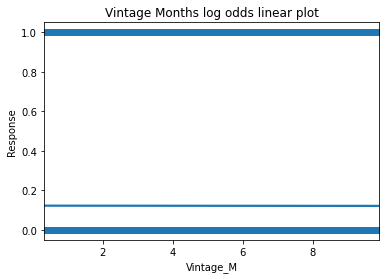

In [9]:
Months_With = sns.regplot(x= 'Vintage_M', y= 'Response', data= fp, logistic= True).set_title("Vintage Months log odds linear plot")


In [8]:
fp['Vehicle_Age'] = fp['Vehicle_Age'].replace({'< 1 Year':0, '1-2 Year':1, '> 2 Years':2})

#Consider turning Policy_Sales_Channel into dummy variables
#Consider turning Region_Code into dummy variables

In [9]:
fp['Gender'] = fp['Gender'].replace({'Male':0, 'Female':1})

In [10]:
fp['Vehicle_Damage'] = fp['Vehicle_Damage'].replace({'Yes':0, 'No':1})

In [11]:
from sklearn.cluster import KMeans


In [12]:
features_to_include = ['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage','Annual_Premium', ]
# Remove 'Policy_Sales_Channel', 'Vintage', and 'Region_Code' because they do not meet conditions and/or do not have clear 
#documentation. In addition, we will remove Vehicle_age for this iteration due to multico

In [13]:
#Check multicollinearity 
multico = fp.corr()
#Vehicle Age and Age of customer are moderately positively correlated. Older customers have older vehicles. Consider dropping one
#Vehicle Damage and Previously Insured are highly correlated which is not surprising. Consider dropping one term

In [14]:
print(multico)

                            id    Gender       Age  Driving_License  \
id                    1.000000 -0.000999  0.001561        -0.000564   
Gender               -0.000999  1.000000 -0.145545         0.018374   
Age                   0.001561 -0.145545  1.000000        -0.079782   
Driving_License      -0.000564  0.018374 -0.079782         1.000000   
Region_Code          -0.000572 -0.000604  0.042574        -0.001081   
Previously_Insured    0.002457  0.081932 -0.254682         0.014969   
Vehicle_Age           0.000878 -0.160427  0.765790        -0.037306   
Vehicle_Damage        0.001507  0.091606 -0.267534         0.016622   
Annual_Premium        0.003027 -0.003673  0.067507        -0.011906   
Policy_Sales_Channel -0.002837  0.111159 -0.577826         0.043731   
Vintage              -0.000630  0.002517 -0.001264        -0.000848   
Response             -0.001368 -0.052440  0.111147         0.010155   

                      Region_Code  Previously_Insured  Vehicle_Age  \
id    

In [15]:
for col in fp.columns:
    fp[col] = fp[col].astype(int)

In [16]:
del fp['Vintage']

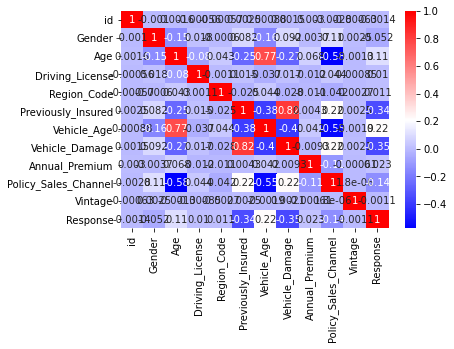

In [17]:
#We are going to make a heat graph of multicollinearity for visual sake
sns.heatmap(multico, annot = True, cmap = 'bwr')

In [18]:
fp

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,0,44,1,28,0,2,0,40454,26,1
1,2,0,76,1,3,0,1,1,33536,26,0
2,3,0,47,1,28,0,2,0,38294,26,1
3,4,0,21,1,11,1,0,1,28619,152,0
4,5,1,29,1,41,1,0,1,27496,152,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,26,1,1,1,30170,26,0
381105,381106,0,30,1,37,1,0,1,40016,152,0
381106,381107,0,21,1,30,1,0,1,35118,160,0
381107,381108,1,68,1,14,0,2,0,44617,124,0


In [19]:
features_to_include_test = ['Gender', 'Age', 'Driving_License',  'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', ]


In [20]:
from sklearn.preprocessing import StandardScaler


In [21]:
scaler = StandardScaler()
scaler.fit(fp[features_to_include])
XS = scaler.transform(fp[features_to_include])
#This trial we are going to remove Vehicle age from features. Another trial we will remove Customer Age

In [22]:
#Scale non-categorical data only
numerical_cols = ['Annual_Premium', 'Age']

scaler = MinMaxScaler()
fp[numerical_cols] = scaler.fit_transform(fp[numerical_cols])

fp.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,0,0.369231,1,28,0,2,0,0.070366,26,1
1,2,0,0.861538,1,3,0,1,1,0.057496,26,0
2,3,0,0.415385,1,28,0,2,0,0.066347,26,1
3,4,0,0.015385,1,11,1,0,1,0.048348,152,0
4,5,1,0.138462,1,41,1,0,1,0.046259,152,0


In [23]:
XS

array([[-0.92154476,  0.33377727,  0.04620794, -0.91963797, -0.99029399,
         0.57453868],
       [-0.92154476,  2.39675074,  0.04620794, -0.91963797,  1.00980114,
         0.17263624],
       [-0.92154476,  0.52718104,  0.04620794, -0.91963797, -0.99029399,
         0.4490531 ],
       ...,
       [-0.92154476, -1.14898491,  0.04620794,  1.08738442,  1.00980114,
         0.26454281],
       [ 1.08513449,  1.88100737,  0.04620794, -0.91963797, -0.99029399,
         0.81638891],
       [-0.92154476,  0.46271311,  0.04620794, -0.91963797,  1.00980114,
         0.6513986 ]])

In [24]:
k_means_model = KMeans(n_clusters = 2)
k_means_model.fit(X)

NameError: name 'X' is not defined

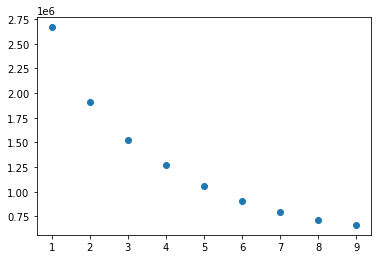

In [36]:
inertia_list = []
k_range = np.arange(1,10)
for k in k_range:
    k_means_model = KMeans(n_clusters = k)
    k_means_model.fit(X)
    inertia_list.append(k_means_model.inertia_)

plt.scatter(k_range,inertia_list)
plt.show()

In [25]:
#Looks like 4 is the elbow. Let's do k-means with 3, 4, and 5 clusters
four_means_model = KMeans(n_clusters = 4)
four_means_model.fit(X);

three_means_model = KMeans(n_clusters = 3)
three_means_model.fit(X);

five_means_model = KMeans(n_clusters = 5)
five_means_model.fit(X)

NameError: name 'X' is not defined

In [26]:
two_means_model = KMeans(n_clusters = 2)
two_means_model.fit(X)

NameError: name 'X' is not defined

In [27]:
two_means_model.labels_

AttributeError: 'KMeans' object has no attribute 'labels_'

In [28]:
from sklearn.metrics import accuracy_score


In [38]:
X

array([[-0.92154476,  0.33377727,  0.04620794, ...,  2.45028138,
        -0.99029399,  0.57453868],
       [-0.92154476,  2.39675074,  0.04620794, ...,  0.68797635,
         1.00980114,  0.17263624],
       [-0.92154476,  0.52718104,  0.04620794, ...,  2.45028138,
        -0.99029399,  0.4490531 ],
       ...,
       [-0.92154476, -1.14898491,  0.04620794, ..., -1.07432868,
         1.00980114,  0.26454281],
       [ 1.08513449,  1.88100737,  0.04620794, ...,  2.45028138,
        -0.99029399,  0.81638891],
       [-0.92154476,  0.46271311,  0.04620794, ...,  0.68797635,
         1.00980114,  0.6513986 ]])

In [29]:
from sklearn.decomposition import PCA


In [30]:
from sklearn import decomposition

In [31]:

#Build and fit a PCA model to the data
my_pca = PCA(n_components=2)
my_pca.fit(XS)
my_pca_test = PCA(n_components = 2)
#my_pca_test.fit(Xt)
my_pca2 = PCA(n_components= 3)
my_pca2.fit(XS)
#my_pca_test2 = PCA(n_components = 3)
#my_pca_test2.fit(Xt)

#X2_test = PCA(n_components = 2)
#Transform the data
X_PCA = my_pca.transform(XS)
#X_PCA_test = my_pca_test.transform(Xt)
X2_PCA = my_pca2.transform(XS)
#X2_PCA_test = my_pca_test2.transform(Xt)

In [32]:
print(X_PCA)

[[ 1.52393554  0.4102053 ]
 [ 0.97822854  1.4945978 ]
 [ 1.59151165  0.43243589]
 ...
 [-1.61695968  0.50015282]
 [ 1.76584169  0.227652  ]
 [ 0.27956086  0.90859558]]


In [33]:
print(abs(my_pca.components_))

[[0.16717712 0.36855459 0.05336116 0.64329313 0.64705078 0.02951519]
 [0.47051849 0.41900006 0.54027863 0.22329039 0.20416415 0.46862427]]


In [34]:
print(my_pca.explained_variance_ratio_)

[0.33286785 0.17928898]


In [35]:
print(my_pca2.explained_variance_ratio_)

[0.33286785 0.17928898 0.1653811 ]


In [36]:
fptest

NameError: name 'fptest' is not defined

Text(0, 0.5, 'pca d 2')

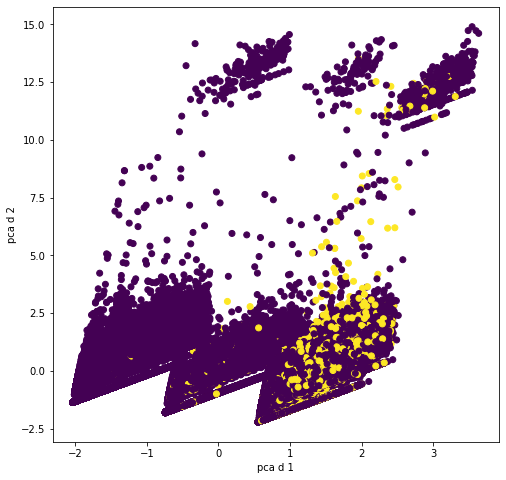

In [54]:
plt.figure(figsize=(8,8))
plt.scatter(X_PCA[:,0], X_PCA[:,1],c=fp['Response'])
plt.xlabel('pca d 1')
plt.ylabel('pca d 2')

In [46]:
X_PCA.shape

(381109, 2)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [15]:
import sklearn.pipeline as skpl ##Convenient module for calculating PCs and using them in logistic regression

In [50]:
pca = PCA(n_components = 2)

In [51]:
logreg = LogisticRegression()

In [52]:
pipe = skpl.Pipeline(steps =[('pca', pca), ('logreg', logreg)]) #we need to run multiple iterations to test best fit

In [53]:
logreg

LogisticRegression()

In [54]:
pipe

Pipeline(steps=[('pca', PCA(n_components=2)), ('logreg', LogisticRegression())])

In [55]:
train1 = X_PCA
y = fp['Response']
logreg.fit(train1, y)
#This is a poor training model with lots of overfitting. We will try splitting the data and making a training and test set next

LogisticRegression()

In [56]:
print("The classification accuracy is: %3.3f" % (logreg.score(X_PCA,y)* 100))

The classification accuracy is: 87.743


In [57]:
logreg.score(X_PCA,y) #Good accuracy

0.8774340149406076

In [58]:
test1 = X_PCA_test
preds = logreg.predict(test1) 

In [59]:
logreg.score(X_PCA_test, preds) #lol way overfitting

1.0

In [38]:
from sklearn.model_selection import train_test_split


In [61]:

X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.4,) #Split up training data and test


In [62]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X,y, test_size = 0.4) #Try scaled data only

In [64]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_PCA, y, test_size=0.2, ) #PCA with 3 components

In [65]:
logreg2 = LogisticRegression()
logreg2.fit(X2_train, y2_train)
preds2 = logreg2.predict(X2_test)
print(accuracy_score(y2_test, preds2))

0.876571068720317


In [66]:
logreg.fit(X_train, y_train)

LogisticRegression()

In [67]:
preds = logreg.predict(X_test)

In [68]:
print(accuracy_score(y_test, preds)) #Still overfitting????????

0.8773976017422791


In [69]:
predstest = logreg.predict(test1)

In [70]:
predstest

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:
predstest.view

<function ndarray.view>

In [66]:
np.set_printoptions(edgeitems = 10000)
print(predstest)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [71]:
y_test.value_counts()

0    133754
1     18690
Name: Response, dtype: int64

In [72]:
okay = pd.read_csv('sample_submissionfp.csv')

In [73]:
okay #These are all 0's

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,0
127034,508144,0
127035,508145,0


In [74]:
print(accuracy_score(okay['Response'], predstest)) #okay 0.9397577083841715

0.9588151483426088


In [76]:
#try with 3 dimensions
train2 = X2_PCA
y = fp['Response']
logreg.fit(train2, y)
logreg.score(X2_PCA,y) #Overfitting shieeeeeeeeeeeeeeeeeee

0.877436638861848

In [77]:
test2 = X2_PCA_test
predstest2 = logreg.predict(test2) #More overfitting

In [78]:
print(accuracy_score(okay['Response'], predstest2)) #accuracy increases with three components
print(accuracy_score(y_test, preds))
print(accuracy_score(okay['Response'], predstest))
print(accuracy_score(y2_test, preds2))
print(accuracy_score(yp_test, preds6))
#weird values
#0.9633807473413257
#0.9972711290703471
#0.9397577083841715
#0.997336726929233

0.9558711241606775
0.8773976017422791
0.9588151483426088
0.876571068720317
0.8768334601558605


In [39]:
from sklearn.metrics import f1_score
#A way of checking a model's performance. 0 is bad, 1 is best.

In [80]:

print(f1_score(okay['Response'], predstest2))
print(f1_score(y_test, preds))
print(f1_score(okay['Response'],predstest)) #but f1 score is 0??? Super Overfit???????
print(f1_score(y2_test, preds2))
print(f1_score(yp_test, preds6))
#possible interpretations: One factor is under represented in sample, need to simulate data for higher counts of 
#under represented factor
#change up test size and random state
#Ideally want f1 score between .6 -> .8
#first time values
#0.0
#0.9888220120378332
#0.0
#0.9890936442271531

#these are the weird values I got the second time
#0.0
#0.0
#0.0
#0.0


0.0
0.0
0.0
0.0
0.0


In [76]:
y_test

230682    0
175136    1
312939    0
298527    0
105098    0
         ..
342871    0
335165    0
210032    0
276813    0
55455     0
Name: Response, Length: 152444, dtype: int32

In [81]:
okay

,id,Response
0,381110,0
1,381111,0
2,381112,0
3,381113,0
4,381114,0
...,...,...
127032,508142,0
127033,508143,0
127034,508144,0
127035,508145,0


In [82]:
okay['Response'].value_counts()

0    127037
Name: Response, dtype: int64

In [84]:
okay['Response'].unique() #Only failures are included in validation set. Because of this, I went back to my models
#and split the training data

array([0], dtype=int64)

In [1]:
46710 / 334399

0.13968343206767964

In [85]:
fp['Response'].value_counts()


0    334399
1     46710
Name: Response, dtype: int64

In [82]:
print(logreg.coef_)

[[ 1.0980431  -1.24823526  0.17928482]]


In [81]:
#train3 = fp.drop(['Response', 'Policy_Sales_Channel', 'Vintage', "Region_Code",], axis = 1)
train3 = fp[features_to_include]
X3_train, X3_test, y3_train, y3_test = train_test_split(train3, y, test_size=0.4, )
logreg3 = LogisticRegression()
y = fp['Response']
logreg3.fit(X3_train, y3_train)


LogisticRegression()

In [82]:
preds3 = logreg3.predict(X3_test)

In [83]:
print(accuracy_score(preds3, y3_test))

0.8763677153577707


In [84]:
print(f1_score(preds3, y3_test))

0.0


In [87]:
np.set_printoptions(edgeitems = 1000)
print(preds3)
#Checking model predictions. As we can see, there is an abundance of 0's

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [85]:
#Now lets try log reg while dropping one of the multicorrelated variables 'Vehicle Damage'
#train4 = fp.drop(['Response', 'Policy_Sales_Channel', 'Vintage', "Region_Code", 'Vehicle_Damage',] , axis = 1)
train4 = fp.drop(['Response',  'Vehicle_Damage',] , axis = 1)

X4_train, X4_test, y4_train, y4_test = train_test_split(train4, y, test_size=0.4, )
logreg4 = LogisticRegression()

logreg4.fit(X4_train, y4_train)
preds4 =logreg4.predict(X4_test)
print(accuracy_score(preds4, y4_test))


0.8772467266668416


In [86]:
print(f1_score(preds4, y4_test)) #"highest" f1 score, nearly same performance in logreg, more intuitive than PCA, better model

0.006055133584745312


In [87]:
#Now lets try log reg while dropping one of the multicorrelated variables 'Vehicle Damage' AND dropping variables w/ lowest variance in PCA
train5 = fp.drop(['Response', 'Policy_Sales_Channel', 'Vintage', "Region_Code", 'Previously_Insured','Driving_License', 'Annual_Premium'] , axis = 1)
X5_train, X5_test, y5_train, y5_test = train_test_split(train5, y, test_size=0.4, )
logreg5 = LogisticRegression()

logreg5.fit(X5_train, y5_train)
preds5 =logreg5.predict(X5_test)
print(accuracy_score(preds5, y5_test))


0.8779879824722521


In [88]:
#Models 4 and 5 did not use transformed data... lets try the transformed data but without being treated with PCA
train7 = X
X7_train, X7_test, y7_train, y7_test = train_test_split(train7,y, test_size = 0.4)
logreg7 = LogisticRegression()
logreg7.fit(X7_train, y7_train)
preds7 = logreg7.predict(X7_test)
print(accuracy_score(preds7, y7_test))
print(f1_score(preds7, y7_test))

0.8775091181023852
0.0


In [89]:
print(f1_score(preds5, y5_test)) #ouch f1 score plummeted

0.00042992261392949265


In [40]:
from sklearn.metrics import roc_auc_score
#Another method of checking a model's performance

In [91]:
print(roc_auc_score(y_test, preds))
print(roc_auc_score(y2_test, preds2))
print(roc_auc_score(y4_test, preds4))
print(roc_auc_score(y5_test, preds5))
print(roc_auc_score(yp_test, preds6))
print(roc_auc_score(y7_test, preds7))
#Oh no, our model is worthless lets move onto upscaling

0.5
0.5
0.5011929363151574
0.500010542177252
0.5
0.49999252464996674


In [92]:
#Model 8 will use data where only age and premium are scaled... lets try the transformed data but without being treated with PCA
train8 = fp[features_to_include]
X8_train, X8_test, y8_train, y8_test = train_test_split(train8,y, test_size = 0.4, shuffle = True)
logreg8 = LogisticRegression()
logreg8.fit(X8_train, y8_train)
preds8 = logreg8.predict(X8_test)
print(accuracy_score(preds8, y8_test))
print(f1_score(preds8, y8_test))
print(roc_auc_score(y8_test, preds8))

0.8772139277373987
0.00021365238756543102
0.5000347385510734


In [93]:
fp.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vintage_M
0,0,0.369231,1,28.0,0,2,0,0.070366,26.0,217,1,7.173554
1,0,0.861538,1,3.0,0,1,1,0.057496,26.0,183,0,6.049587
2,0,0.415385,1,28.0,0,2,0,0.066347,26.0,27,1,0.892562
3,0,0.015385,1,11.0,1,0,1,0.048348,152.0,203,0,6.710744
4,1,0.138462,1,41.0,1,0,1,0.046259,152.0,39,0,1.289256


In [97]:
!pip install catboost

  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11435 sha256=3cbdb0b0929e6720220a5514328f5c20f20c81d2dbf69ae9b6309f9560f620bc
  Stored in directory: c:\users\jason kim\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [41]:
fp.drop(['Vintage'], axis = 1)

KeyError: "['Vintage'] not found in axis"

In [42]:
fp['Response'] = fp['Response'].astype(int)

In [43]:
fp.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,0,0.369231,1,28,0,2,0,0.070366,26,1
1,2,0,0.861538,1,3,0,1,1,0.057496,26,0
2,3,0,0.415385,1,28,0,2,0,0.066347,26,1
3,4,0,0.015385,1,11,1,0,1,0.048348,152,0
4,5,1,0.138462,1,41,1,0,1,0.046259,152,0


In [44]:
 from sklearn.metrics import confusion_matrix as cs
    #We want to see how often our model correctly predicted the response. Left column is correct predictions, right column
    # is incorrect. First row is 0, second is 1

In [95]:
cs(y_test, preds, ) #Overfit

array([[133774,      0],
       [ 18670,      0]], dtype=int64)

In [96]:
cs(yp_test, preds6)

array([[133711,      0],
       [ 18733,      0]], dtype=int64)

In [97]:
cs(y4_test, preds4) #Still overfit, but the best performing model yet

array([[132562,   1214],
       [ 17997,    671]], dtype=int64)

In [98]:
cs(y5_test, preds5)

array([[133920,     19],
       [ 18501,      4]], dtype=int64)

In [88]:
cs(y7_test, preds7)

array([[133932,      3],
       [ 18507,      2]], dtype=int64)

In [114]:
preds5

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [101]:
#as we can see from our counts, only models 3,4, and 5 attempt to classify dv's as 1's.
print(np.unique(preds, return_counts = True))
print(np.unique(preds2, return_counts = True))
print(np.unique(preds3, return_counts = True))
print(np.unique(preds4, return_counts = True))
print(np.unique(preds5, return_counts = True))
print(np.unique(preds6, return_counts = True))
#Our first models achieved great accuracy by predicting every response to be 'No'

(array([0]), array([152444], dtype=int64))
(array([0]), array([76222], dtype=int64))
(array([0, 1]), array([152333,    111], dtype=int64))
(array([0, 1]), array([150559,   1885], dtype=int64))
(array([0, 1]), array([152421,     23], dtype=int64))
(array([0]), array([152444], dtype=int64))


In [45]:
#!pip install tensorflow
#!pip install keras 

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
import tensorflow.keras.backend as K

import tensorflow as tf
#Here we try Keras

In [110]:
#I have no idea what I'm doing
#8 digit loss value
epoc = 40 #@param {type:"slider", min:0, max:100, step:1}

#Create Sequential object
model = Sequential()

#Add a dense layers and specify the sigmoid activation function
model.add(Dense(1, input_shape=(6,), activation='sigmoid'))

#Use the SGD optimizer with a lr of 0.5, and use the binary cross entropy loss
model.compile(SGD(lr=0.5), 'binary_crossentropy', metrics=['accuracy'])

model.fit(X4_train, y4_train, epochs=epoc)

Epoch 1/40
7146/7146 [==============================] - 2s 347us/step - loss: 27419450.0000 - accuracy: 0.7814
Epoch 2/40
7146/7146 [==============================] - 2s 338us/step - loss: 27164338.0000 - accuracy: 0.7821
Epoch 3/40
7146/7146 [==============================] - 2s 345us/step - loss: 27221152.0000 - accuracy: 0.7807
Epoch 4/40
7146/7146 [==============================] - 3s 405us/step - loss: 27114206.0000 - accuracy: 0.7817
Epoch 5/40
7146/7146 [==============================] - 3s 410us/step - loss: 27218294.0000 - accuracy: 0.7821
Epoch 6/40
7146/7146 [==============================] - 3s 409us/step - loss: 27294514.0000 - accuracy: 0.7796
Epoch 7/40
7146/7146 [==============================] - 3s 399us/step - loss: 27315894.0000 - accuracy: 0.7806
Epoch 8/40
7146/7146 [==============================] - 3s 375us/step - loss: 27094994.0000 - accuracy: 0.7805
Epoch 9/40
7146/7146 [==============================] - 3s 380us/step - loss: 27095752.0000 - accuracy: 0.7808
E

In [113]:
kpreds = model.predict(X4_test)

In [116]:
print(accuracy_score(kpreds, y4_test))
print(f1_score(kpreds, y4_test))
print(roc_auc_score(y4_test, kpreds))
#Great accuracy score but performance measures are awful

0.877541917031828
0.0
0.5


In [46]:
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical


In [47]:
#Using stack overflow we find a method of fixing the performance of the model through each epoch
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    #true_positives and possible_positives seem to be misnamed
    return recall
#Sum up the rounded 'clipped' value of y_true multiplied by y_pred, where y_true and y_pred are bounded between 0 and 1
# Because this is log regression, clipping should be redundant as all values are 0 or 1 and any misentered responses should be
#removed during data cleaning
#Recall is 1 when there are no false negatives, lower when there are

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#Precision is 1 when predicted = true positives
#however unlike recall, precision is looking at how accurately the model predicted positives. It gets lower when there
#are false positives, not false negatives
def keras_f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [48]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(6),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model

In [49]:
XK = fp[features_to_include]
y = fp['Response']

In [50]:
XK_train, XK_test, yk_train, yk_test = train_test_split(XK, y, test_size=0.2,)

In [51]:
y_nn_train = to_categorical(yk_train)

In [52]:
class_weight = {
    0: 1.,
    1: 8.
}
# We give success 8x the weight because they are ~12% of the responses, a.k.a about 1/8 of the responses

In [29]:
model = create_model()
model.fit(XK_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight)

Epoch 1/35
953/953 - 2s - loss: 0.9389 - keras_f1_score: 0.6525 - val_loss: 0.5202 - val_keras_f1_score: 0.6492
Epoch 2/35
953/953 - 1s - loss: 0.8243 - keras_f1_score: 0.6658 - val_loss: 0.4962 - val_keras_f1_score: 0.6665
Epoch 3/35
953/953 - 1s - loss: 0.8152 - keras_f1_score: 0.6707 - val_loss: 0.5107 - val_keras_f1_score: 0.6623
Epoch 4/35
953/953 - 1s - loss: 0.8124 - keras_f1_score: 0.6702 - val_loss: 0.5184 - val_keras_f1_score: 0.6564
Epoch 5/35
953/953 - 1s - loss: 0.8115 - keras_f1_score: 0.6711 - val_loss: 0.5182 - val_keras_f1_score: 0.6600
Epoch 6/35
953/953 - 1s - loss: 0.8095 - keras_f1_score: 0.6711 - val_loss: 0.5313 - val_keras_f1_score: 0.6622
Epoch 7/35
953/953 - 1s - loss: 0.8079 - keras_f1_score: 0.6708 - val_loss: 0.4997 - val_keras_f1_score: 0.6688
Epoch 8/35
953/953 - 1s - loss: 0.8078 - keras_f1_score: 0.6706 - val_loss: 0.4908 - val_keras_f1_score: 0.6800
Epoch 9/35
953/953 - 1s - loss: 0.8059 - keras_f1_score: 0.6721 - val_loss: 0.5074 - val_keras_f1_score:

In [30]:
predsk = model.predict(XK_test)
predsk = np.argmax(predsk, axis=1)

In [53]:
print(accuracy_score(predsk, yk_test))
print(f1_score(yk_test, predsk))
print(roc_auc_score(yk_test, predsk))
# Accuracy takes a hit but our model is no longer overfitted and now predicts correctly instead of assigning 0's to every input

NameError: name 'predsk' is not defined

In [32]:
cs(yk_test, predsk, ) #now it looks like successes are overweighted. Could alter weights to see better results

array([[41584, 25337],
       [  374,  8927]], dtype=int64)

In [62]:
class_weight2 = {
    0: 1.,
    1: 7.
}
#Actually, the proportions are closer to 7:1, so lets make a second model with the updated class weight

In [34]:
model2 = create_model()
model2.fit(XK_train, y_nn_train, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8262 - keras_f1_score: 0.6611 - val_loss: 0.4770 - val_keras_f1_score: 0.6664
Epoch 2/35
953/953 - 1s - loss: 0.7735 - keras_f1_score: 0.6818 - val_loss: 0.4574 - val_keras_f1_score: 0.6989
Epoch 3/35
953/953 - 1s - loss: 0.7684 - keras_f1_score: 0.6835 - val_loss: 0.4661 - val_keras_f1_score: 0.6951
Epoch 4/35
953/953 - 1s - loss: 0.7660 - keras_f1_score: 0.6831 - val_loss: 0.4642 - val_keras_f1_score: 0.6923
Epoch 5/35
953/953 - 1s - loss: 0.7652 - keras_f1_score: 0.6836 - val_loss: 0.4688 - val_keras_f1_score: 0.6859
Epoch 6/35
953/953 - 1s - loss: 0.7647 - keras_f1_score: 0.6815 - val_loss: 0.4658 - val_keras_f1_score: 0.6959
Epoch 7/35
953/953 - 1s - loss: 0.7630 - keras_f1_score: 0.6837 - val_loss: 0.4800 - val_keras_f1_score: 0.6703
Epoch 8/35
953/953 - 1s - loss: 0.7628 - keras_f1_score: 0.6835 - val_loss: 0.4657 - val_keras_f1_score: 0.6859
Epoch 9/35
953/953 - 1s - loss: 0.7628 - keras_f1_score: 0.6820 - val_loss: 0.4914 - val_keras_f1_score:

In [35]:
predsk2 = model2.predict(XK_test)
predsk2 = np.argmax(predsk2, axis=1)

In [36]:
print(accuracy_score(predsk2, yk_test))
print(f1_score(yk_test, predsk2))
print(roc_auc_score(yk_test, predsk2))


0.69376295557713
0.4240525069088038
0.792829730451888


In [37]:
cs(yk_test, predsk2, )

array([[44287, 22634],
       [  708,  8593]], dtype=int64)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y, test_size=0.4,) #Split up training data and test


In [55]:
y_nn_train2 = to_categorical(y_train)

In [56]:
def create_model2():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(2),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model

In [63]:
modelpca = create_model2()
modelpca.fit(X_train, y_nn_train2, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
715/715 - 1s - loss: 0.9364 - keras_f1_score: 0.6488 - val_loss: 0.4914 - val_keras_f1_score: 0.6434
Epoch 2/35
715/715 - 1s - loss: 0.8172 - keras_f1_score: 0.6498 - val_loss: 0.4888 - val_keras_f1_score: 0.6403
Epoch 3/35
715/715 - 1s - loss: 0.8045 - keras_f1_score: 0.6473 - val_loss: 0.4962 - val_keras_f1_score: 0.6410
Epoch 4/35
715/715 - 1s - loss: 0.7988 - keras_f1_score: 0.6468 - val_loss: 0.4867 - val_keras_f1_score: 0.6411
Epoch 5/35
715/715 - 1s - loss: 0.7976 - keras_f1_score: 0.6456 - val_loss: 0.4857 - val_keras_f1_score: 0.6409
Epoch 6/35
715/715 - 1s - loss: 0.7954 - keras_f1_score: 0.6459 - val_loss: 0.5051 - val_keras_f1_score: 0.6406
Epoch 7/35
715/715 - 1s - loss: 0.7941 - keras_f1_score: 0.6451 - val_loss: 0.4883 - val_keras_f1_score: 0.6422
Epoch 8/35
715/715 - 1s - loss: 0.7923 - keras_f1_score: 0.6459 - val_loss: 0.4849 - val_keras_f1_score: 0.6409
Epoch 9/35
715/715 - 1s - loss: 0.7893 - keras_f1_score: 0.6477 - val_loss: 0.4949 - val_keras_f1_score:

KeyboardInterrupt: 

In [62]:
predspca = modelpca.predict(X_test)
predspca= np.argmax(predspca, axis=1)

In [63]:
print(accuracy_score(predspca, y_test))
print(f1_score(y_test, predspca))
print(roc_auc_score(y_test, predspca))


0.6380441342394584
0.39595831326356357
0.7833443531819155


In [64]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_PCA, y, test_size=0.2, random_state=666)

In [65]:
def create_model3():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(3),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(2, activation='softmax')
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy, 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=[keras_f1_score]
    )
    return model

In [66]:
y_nn_train3 = to_categorical(y2_train)

In [74]:
modelpca = create_model3()
modelpca.fit(X2_train, y_nn_train3, validation_split=0.2, epochs=35, batch_size=256, verbose=2, class_weight=class_weight2)

Epoch 1/35
953/953 - 1s - loss: 0.8889 - keras_f1_score: 0.6587 - val_loss: 0.5108 - val_keras_f1_score: 0.6404
Epoch 2/35
953/953 - 1s - loss: 0.8104 - keras_f1_score: 0.6524 - val_loss: 0.4936 - val_keras_f1_score: 0.6391
Epoch 3/35
953/953 - 1s - loss: 0.8000 - keras_f1_score: 0.6504 - val_loss: 0.4912 - val_keras_f1_score: 0.6389
Epoch 4/35
953/953 - 1s - loss: 0.7934 - keras_f1_score: 0.6523 - val_loss: 0.5136 - val_keras_f1_score: 0.6387
Epoch 5/35
953/953 - 1s - loss: 0.7919 - keras_f1_score: 0.6530 - val_loss: 0.4860 - val_keras_f1_score: 0.6389
Epoch 6/35
953/953 - 1s - loss: 0.7893 - keras_f1_score: 0.6546 - val_loss: 0.4781 - val_keras_f1_score: 0.6404
Epoch 7/35
953/953 - 1s - loss: 0.7901 - keras_f1_score: 0.6542 - val_loss: 0.4909 - val_keras_f1_score: 0.6426
Epoch 8/35
953/953 - 1s - loss: 0.7894 - keras_f1_score: 0.6539 - val_loss: 0.4726 - val_keras_f1_score: 0.6398
Epoch 9/35
953/953 - 1s - loss: 0.7881 - keras_f1_score: 0.6554 - val_loss: 0.4857 - val_keras_f1_score:

In [84]:
predspca2 = modelpca.predict(X2_test)
predspca2 = np.argmax(predspca2,axis = 1 )

In [86]:
predspca2.shape

(76222,)

In [76]:
y2_test.unique()

array([0, 1])

In [77]:
y2_test.value_counts()

0    66814
1     9408
Name: Response, dtype: int64

In [78]:
y2_test.shape

(76222,)

In [79]:
X2_PCA.shape

(381109, 3)

In [80]:
preds

NameError: name 'preds' is not defined

In [81]:
y2_test.head()

287975    0
303170    0
200661    0
59206     0
159458    0
Name: Response, dtype: int32

In [85]:
print(accuracy_score(predspca2, y2_test))
print(f1_score(y2_test, predspca2))
print(roc_auc_score(y2_test, predspca2))


0.6469523234761617
0.4055403375452859
0.78816326918785


In [75]:
y

0         1
1         0
2         1
3         0
4         0
         ..
381104    0
381105    0
381106    0
381107    0
381108    0
Name: Response, Length: 381109, dtype: int64